In [54]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as s
from numpy import cos, sqrt, radians

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

In [6]:
dataset = pd.read_csv("merged_data.csv")
dataset.columns

Index(['Compounds', 'A sites', 'A site charge',
       'Principle components of inertia', 'B sites', 'Elpasolite?',
       'B site charge', 'B1 site', 'B1 charge', 'B1 ionic radii', 'B2 site',
       'B2 charge', 'B2 ionic radii', 'X sites', 'X site charge',
       'X site length', 'T c/K', 'No. of phase transitions', 'Space groupa',
       'Space group ref', 'a', 'da', 'b_x', 'db', 'c', 'dc', 'alpha', 'dalpha',
       'beta', 'dbeta', 'gamma', 'dgamma', 'Ref.', 'DOI', 'alpha1', 'alpha2',
       'alpha3', 'alphar', 'alphatheta', 'Lmin', 'Lmed', 'Lmax', 'b_y'],
      dtype='object')

In [7]:
def get_HT_parameter(col):
    """Split col at commas and return the last value as a float."""
    return col.str.split(",").str.get(-1).astype(float)

HT_cells = dataset[["a", "b_x", "c", "alpha", "beta", "gamma"]].apply(get_HT_parameter)

def volume(a, b, c, al_d, be_d, ga_d):
    """Calculate the unit cell volume from the parameters a, b, c, alpha, beta, gamma.
    
    Angles in degrees."""
    # http://duffy.princeton.edu/sites/default/files/pdfs/links/xtalgeometry.pdf
    al, be, ga = map(radians, (al_d, be_d, ga_d))
    return a*b*c * sqrt(1 - cos(al)**2 - cos(be)**2 - cos(ga)**2
                       + 2*cos(al)*cos(be)*cos(ga))

vol_array = np.array(dataset['Compounds'] * 0)

HT_cells["V"] = volume(HT_cells["a"], HT_cells["b_x"], HT_cells["c"],
                       HT_cells["alpha"], HT_cells["beta"], HT_cells["gamma"])

HT_cells.dropna(inplace=True)
vol_array = np.array(HT_cells["V"])
data = np.empty(shape = (96, 2))
 
for i in range (0, 96):
    data[i, 1] = vol_array[i]
    data[i, 0] = dataset['X site length'][i]

#print(array)

C:\Users\Henry\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


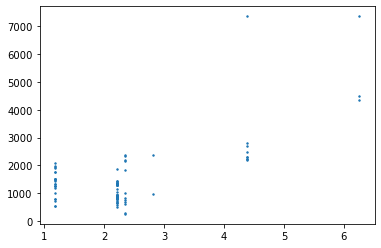

In [8]:
data.sort()
plt.scatter(data[:,0], data[:,1], s = 2)

# Linear Regression

In [9]:
X, y = data[:, :-1], data[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)

In [10]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

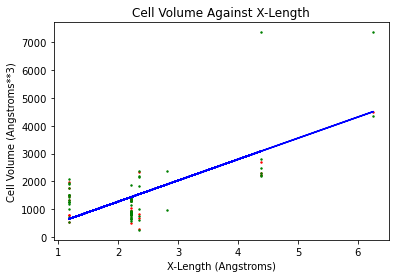

In [11]:
plt.scatter(X_test, y_test, color = 'red', s = 2)
plt.scatter(X_train, y_train, color = 'green', s = 2)
plt.plot(X_train, regressor.predict(X_train), color = 'blue')
plt.title('Cell Volume Against X-Length')
plt.xlabel('X-Length (Angstroms)')
plt.ylabel('Cell Volume (Angstroms**3)')
plt.show()

In [12]:
y_pred = regressor.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('RMS Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 533.7496992701165
RMS Error: 646.9729516531437


# SVM Regression

In [13]:
y = y.reshape(len(y),1)

#Feature Scaling
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)

In [48]:
regressor = SVR(kernel = 'poly', degree = 3)
regressor.fit(X, y)

C:\Users\Henry\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVR(kernel='poly')

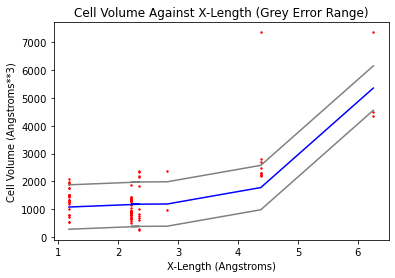

In [49]:
y_pred = sc_y.inverse_transform(regressor.predict(X))

plt.scatter(sc_X.inverse_transform(X), sc_y.inverse_transform(y), color = 'red', s = 2)
plt.plot(sc_X.inverse_transform(X), sc_y.inverse_transform(regressor.predict(X)), color = 'blue')
plt.plot(sc_X.inverse_transform(X),sc_y.inverse_transform(regressor.predict(X))+np.sqrt(metrics.mean_squared_error(sc_y.inverse_transform(y), y_pred)), color = 'grey')
plt.plot(sc_X.inverse_transform(X),sc_y.inverse_transform(regressor.predict(X))-np.sqrt(metrics.mean_squared_error(sc_y.inverse_transform(y), y_pred)), color = 'grey')
plt.title('Cell Volume Against X-Length (Grey Error Range)')
plt.xlabel('X-Length (Angstroms)')
plt.ylabel('Cell Volume (Angstroms**3)')
plt.show()

In [50]:
y_pred = sc_y.inverse_transform(regressor.predict(X))

print('Mean Absolute Error:', metrics.mean_absolute_error(sc_y.inverse_transform(y), y_pred))
print('RMS Error:', np.sqrt(metrics.mean_squared_error(sc_y.inverse_transform(y), y_pred)))

Mean Absolute Error: 511.8643671096666
RMS Error: 798.2863326283265


In [56]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

sk.model_selection.GridSearchCV(regressor, parameters)

GridSearchCV(estimator=SVR(kernel='poly'),
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')})